#**Random Forest Project on New York taxi fares**

For this project we will try to predict taxi prices based on their pick up and destination locations also time of the day.

**Research Question**: Can we predict taxi fare in New York based on amount of passangers, pick up and drop off location?

Github Link : 

In [ ]:
# Importing libraries here.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import urllib.request
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Concatenate
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
# Mounting google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Data Overview**
We will use a data frame with 55 million observations on the following 8 variables.

**Data fields**

ID

* key - Unique string identifying each row in both the training and test sets. Comprised of pickup_datetime plus a unique integer, but this doesn't matter, it should just be used as a unique ID field.

**Features**

* pickup_datetime - timestamp value indicating when the taxi ride started.
* pickup_longitude - float for longitude coordinate of where the taxi ride started.
* pickup_latitude - float for latitude coordinate of where the taxi ride started.
* dropoff_longitude - float for longitude coordinate of where the taxi ride ended.
* dropoff_latitude - float for latitude coordinate of where the taxi ride ended.
passenger_count - integer indicating the number of passengers in the taxi ride.

**Target**

* fare_amount - float dollar amount of the cost of the taxi ride. This value is only in the training set.

Data quality is good, It is provided by google for competition on Kaggle so that any participant should have used train set for training and test with testing set and create sumbission scv file with the result then upload it. In my case I can't do that here in google colab so I am going to use purely training set for both training and testing. I realised it later on so testing sets will be named val(validation).

The training csv file was nearly 5 gb consists of 55 millions records which is way too much so we only took 2 millions. I tried to import all data but my pc nearly crashed and caught fire so yeah.

Dataset can be found: [Here](https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction)

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/TaxiFare/train.csv" ,nrows = 2_000_000, parse_dates=["pickup_datetime"])
test = pd.read_csv("/content/drive/MyDrive/TaxiFare/test (1).csv")

## **EDA and Cleansing**

In [ ]:
train.shape


(2000000, 8)

In [ ]:
train.head()

key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  
0                1  
1                1  
2                2  
3                1  
4                1

In [ ]:
train.dtypes

key                               object
fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

In [ ]:
train.describe()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  2.000000e+06      2.000000e+06     2.000000e+06       1.999986e+06   
mean   1.134779e+01     -7.252321e+01     3.992963e+01      -7.252395e+01   
std    9.852883e+00      1.286804e+01     7.983352e+00       1.277497e+01   
min   -6.200000e+01     -3.377681e+03    -3.458665e+03      -3.383297e+03   
25%    6.000000e+00     -7.399208e+01     4.073491e+01      -7.399141e+01   
50%    8.500000e+00     -7.398181e+01     4.075263e+01      -7.398016e+01   
75%    1.250000e+01     -7.396713e+01     4.076710e+01      -7.396369e+01   
max    1.273310e+03      2.856442e+03     2.621628e+03       3.414307e+03   

       dropoff_latitude  passenger_count  
count      1.999986e+06     2.000000e+06  
mean       3.992808e+01     1.684113e+00  
std        1.032382e+01     1.314982e+00  
min       -3.461541e+03     0.000000e+00  
25%        4.073400e+01     1.000000e+00  
50%        4.075312e+01     1.000000e+00  
75%        4.076809e+01     2.000000e+00  
max        3.345917e+03     2.080000e+02

The following things I notice
The minimal fare_amount is negative. As this does not seem to be realistic I will drop them from the dataset.
Some of the minimum and maximum longitude/lattitude coordinates are way off. These I will also remove from the dataset

In [ ]:
print('Old size: %d' % len(train))
train = train[train.fare_amount>=0]
print('New size: %d' % len(train))

Old size: 2000000
New size: 1999923


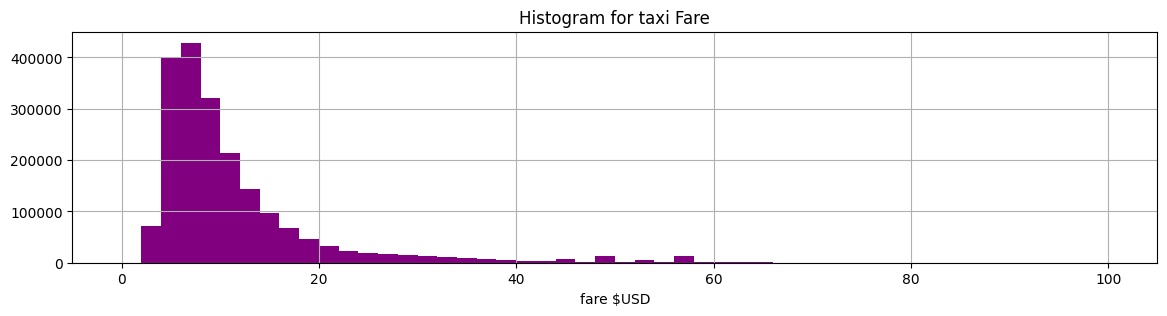

In [ ]:
train[train.fare_amount<100].fare_amount.hist(bins=50, figsize=(14,3), color = 'purple')
plt.xlabel('fare $USD')
plt.title('Histogram for taxi Fare');

Removing missing Data

In [ ]:
print(train.isnull().sum())

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    14
dropoff_latitude     14
passenger_count       0
dtype: int64


In [ ]:
print('Old size: %d' % len(train))
train = train.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train))

Old size: 1999923
New size: 1999909


In [ ]:
test.head()

key          pickup_datetime  pickup_longitude  \
0  2015-01-27 13:08:24.0000002  2015-01-27 13:08:24 UTC        -73.973320   
1  2015-01-27 13:08:24.0000003  2015-01-27 13:08:24 UTC        -73.986862   
2  2011-10-08 11:53:44.0000002  2011-10-08 11:53:44 UTC        -73.982524   
3  2012-12-01 21:12:12.0000002  2012-12-01 21:12:12 UTC        -73.981160   
4  2012-12-01 21:12:12.0000003  2012-12-01 21:12:12 UTC        -73.966046   

   pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  
0        40.763805         -73.981430         40.743835                1  
1        40.719383         -73.998886         40.739201                1  
2        40.751260         -73.979654         40.746139                1  
3        40.767807         -73.990448         40.751635                1  
4        40.789775         -73.988565         40.744427                1

In [ ]:
test.describe()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
count       9914.000000      9914.000000        9914.000000       9914.000000   
mean         -73.974722        40.751041         -73.973657         40.751743   
std            0.042774         0.033541           0.039072          0.035435   
min          -74.252193        40.573143         -74.263242         40.568973   
25%          -73.992501        40.736125         -73.991247         40.735254   
50%          -73.982326        40.753051         -73.980015         40.754065   
75%          -73.968013        40.767113         -73.964059         40.768757   
max          -72.986532        41.709555         -72.990963         41.696683   

       passenger_count  
count      9914.000000  
mean          1.671273  
std           1.278747  
min           1.000000  
25%           1.000000  
50%           1.000000  
75%           2.000000  
max           6.000000

Location data
As we're dealing with location data, I want to plot the coordinates on a map. This gives a better view of the data. For this, I use the following website:

Easy to use map and GPS tool: https://www.gps-coordinates.net/

Calculate distance between locations: https://www.travelmath.com/flying-distance/

Open street map to grab using bouding box a map: https://www.openstreetmap.org/export#map=8/52.154/5.295

New York city coordinates are (https://www.travelmath.com/cities/New+York,+NY):

longitude = -74.0063889
lattitude = 40.7141667
I define a bounding box of interest by [long_min, long_max, latt_min, latt_max] using the minimum and maximum coordinates from the testset. This way, I'm sure to train a model for the full pickup/dropoff coordinate range of the test set.

From Open Street Map I grab a map and I drop any datapoint outside this box

In [ ]:
# minimum longitude test set
min(test.pickup_longitude.min(), test.dropoff_longitude.min())

-74.263242

In [ ]:
# maximum longitude test set
max(test.pickup_longitude.max(), test.dropoff_longitude.max())

-72.986532

In [ ]:
# minimum latitude test
min(test.pickup_latitude.min(), test.dropoff_latitude.min())

40.568973

In [ ]:
# maximum latitude test
max(test.pickup_latitude.max(), test.dropoff_latitude.max())

41.709555

I was able to plot this images with these links:

https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png

https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png

Thanks to ALBERT VAN BREEMEN

In [ ]:
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])

# load image of NYC map
#Boudning BOX
BB = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('/content/drive/MyDrive/TaxiFare/NYC_map.png')

# load extra image to zoom in on NYC
BB_zoom = (-74.3, -73.7, 40.5, 40.9)
nyc_map_zoom = plt.imread('/content/drive/MyDrive/TaxiFare/NYC_map_close.png')

In [ ]:
print('Old size: %d' % len(train))
train = train[select_within_boundingbox(train, BB)]
print('New size: %d' % len(train))

Old size: 1999909
New size: 1957918


In [ ]:
# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='purple', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='purple', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

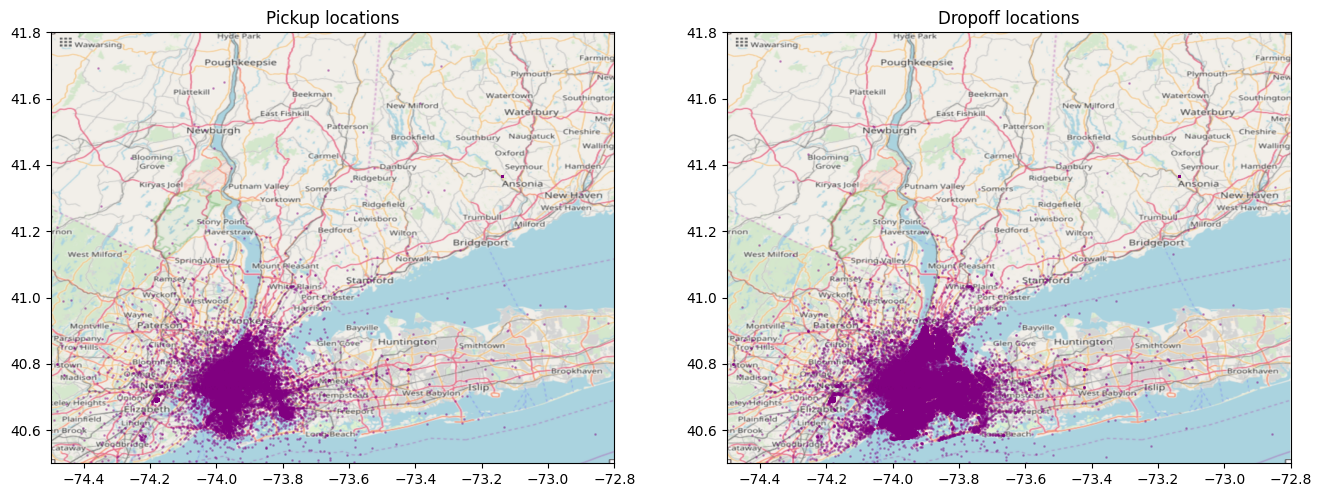

In [ ]:
plot_on_map(train, BB, nyc_map, s=1, alpha=0.3)

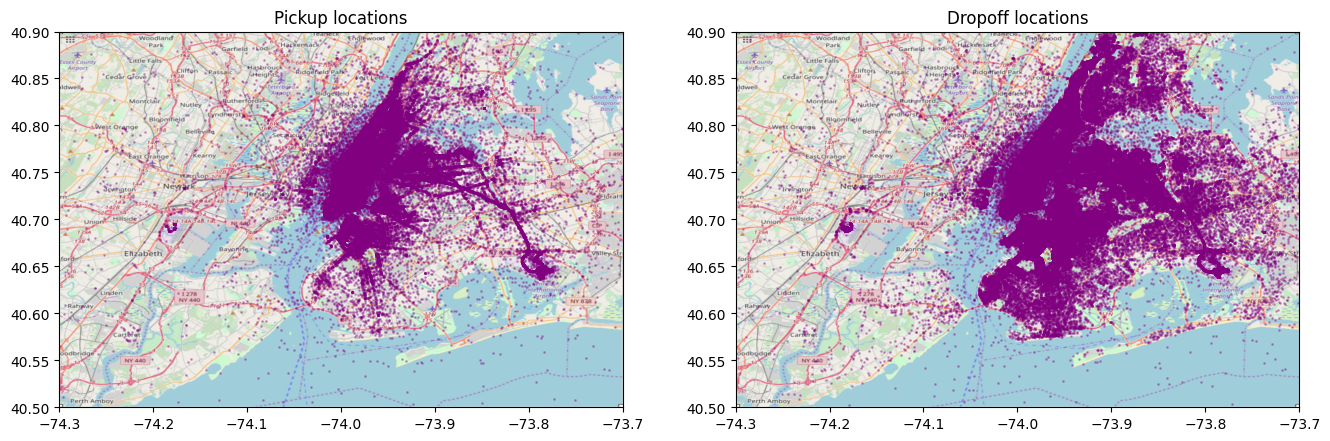

In [ ]:
plot_on_map(train, BB_zoom, nyc_map_zoom, s=1, alpha=0.3)

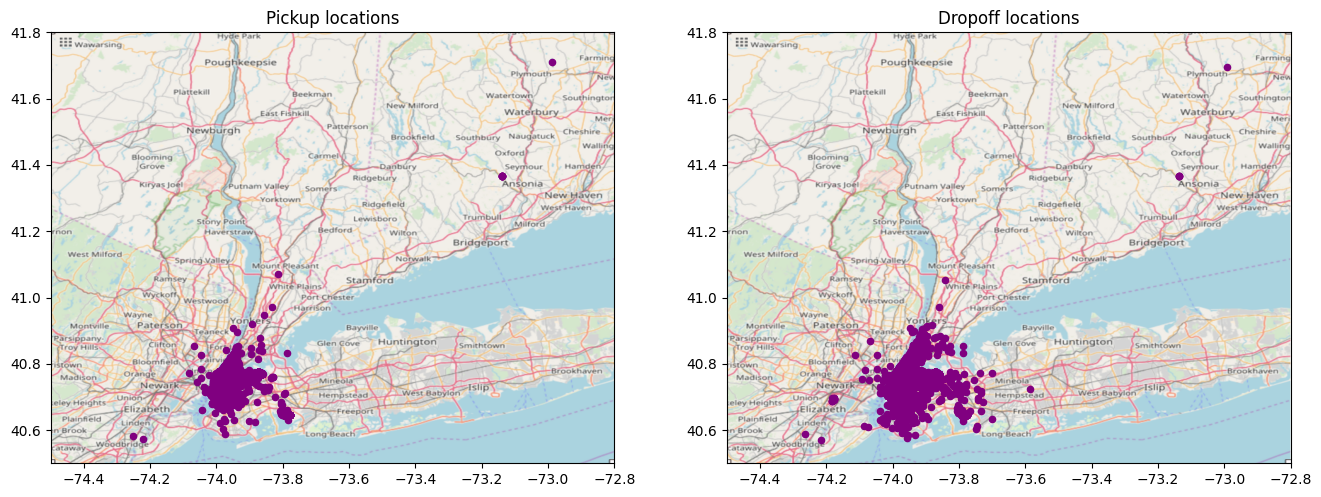

In [ ]:
# plot test data on map
plot_on_map(test, BB, nyc_map, alpha=1.0, s=20)

From the training data scatter plot we see that some locations are in the water. Either these are considered as noise, or we drop them from the dataset.

Mask image can be found here:

https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png

Or else you can gently ask Chatgpt to create for you with following prompt:

Analyse this picture and give me white and black mask where black indicates water and white indicates land areas.

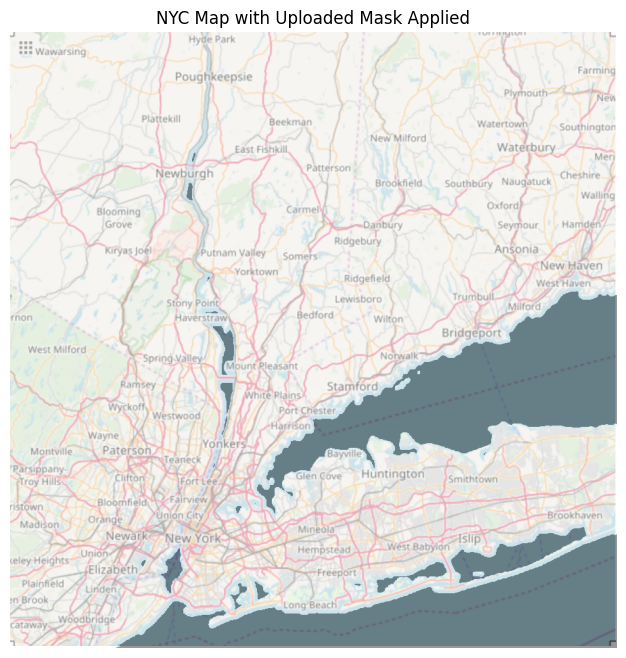

In [ ]:
from PIL import Image
import urllib.request

mask_image_path = '/content/drive/MyDrive/TaxiFare/NYC_mask.png'
mask_image = Image.open(mask_image_path)
nyc_mask = np.array(mask_image)[:,:,0] > 0.9

# Load your local NYC map image
nyc_map_path = '/content/drive/MyDrive/TaxiFare/NYC_map.png'
nyc_map = plt.imread(nyc_map_path)

# Plot the map with the mask applied
plt.figure(figsize=(8, 8))
plt.imshow(nyc_map, zorder=0)
plt.imshow(nyc_mask, cmap='gray', alpha=0.4, zorder=1)
plt.title("NYC Map with Uploaded Mask Applied")
plt.axis('off')
plt.show()


Next, I need to convert longitude/latitude coordinates to xy pixel coordinates. The function lonlat_to_xy implements this transformation. The y coordinate needs to be reversed as the image y-axis is directed from top to bottom.

Once for all datapoints the xy pixel coordinates are calculate a boolean index is calculated using the NYC mask.

In [ ]:
# translate longitude/latitude coordinate into image xy coordinate
def lonlat_to_xy(longitude, latitude, dx, dy, BB):
    return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
           (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

In [ ]:
pickup_x, pickup_y = lonlat_to_xy(train.pickup_longitude, train.pickup_latitude,
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)
dropoff_x, dropoff_y = lonlat_to_xy(train.dropoff_longitude, train.dropoff_latitude,
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)

In [ ]:
idx = (nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x])
print("Number of trips in water: " ,np.sum(~idx))

Number of trips in water:  344


In [ ]:
def remove_datapoints_from_water(df):
    def lonlat_to_xy(longitude, latitude, dx, dy, BB):
        return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
               (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

    # define bounding box
    BB = (-74.5, -72.8, 40.5, 41.8)

    # read nyc mask and turn into boolean map with
    # land = True, water = False
    mask_image_path = '/content/drive/MyDrive/TaxiFare/NYC_mask.png'
    mask_image = Image.open(mask_image_path)
    nyc_mask = np.array(mask_image)[:,:,0] > 0.9
    # calculate for each lon,lat coordinate the xy coordinate in the mask map
    pickup_x, pickup_y = lonlat_to_xy(df.pickup_longitude, df.pickup_latitude,
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)
    dropoff_x, dropoff_y = lonlat_to_xy(df.dropoff_longitude, df.dropoff_latitude,
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)
    # calculate boolean index
    idx = nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x]

    # return only datapoints on land
    return df[idx]

In [ ]:
print('Old size: %d' % len(train))
train = remove_datapoints_from_water(train)
print('New size: %d' % len(train))

Old size: 1957918
New size: 1957574


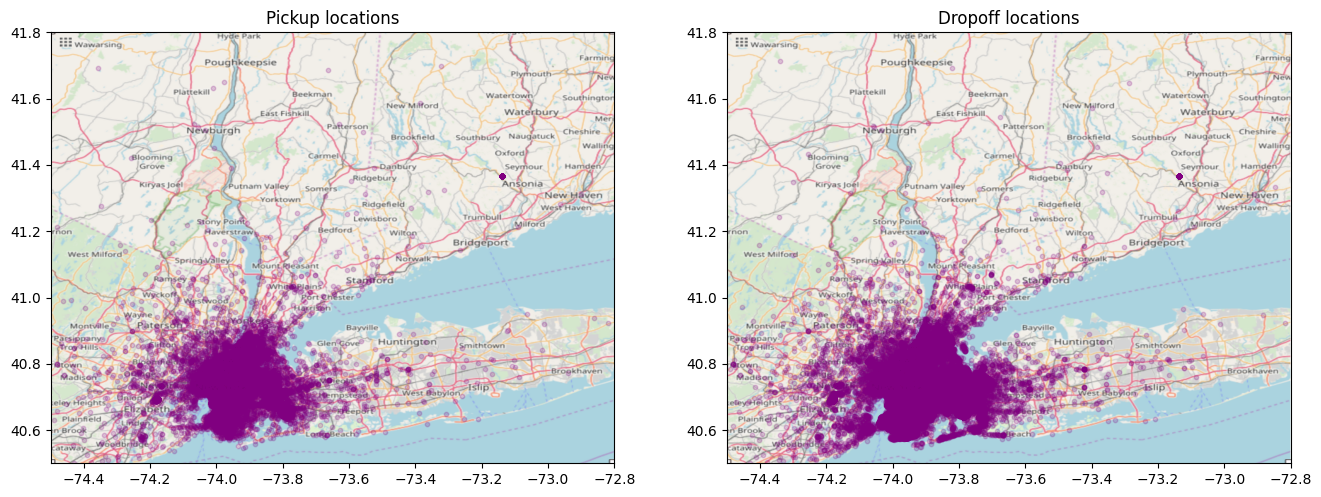

In [ ]:
plot_on_map(train, BB, nyc_map)

#I don't really see datapoints on water so that is good :D.

**Distance**

A useful feature to predict the fare would be the distance travelled during the trip. Since the coordinates are on a sphere, a straight line distance between the pickup and drop coordinates is likely to be an inaccurate measure of the actual distance travelled.

We have used the haversine distance which gives the distance between two points on a sphere:

Link can be found here:
https://www.movable-type.co.uk/scripts/latlong.html

In [ ]:
# Distance between pickup and drop coordinates
def haversine(lon1, lat1, lon2, lat2):
  """
  Calculate the distance between 2 points on a sphere in km
  """
  r = 6371            #Radius of Earth in km
  lon1, lat1, lon2, lat2 = map(np.radians, [lon1,lat1,lon2,lat2])
  delta_lon = lon2-lon1
  delta_lat = lat2-lat1

  #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
  a = np.sin(delta_lat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(delta_lon/2)**2

  #c = 2 * atan2( √a, √(1−a) )
  c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))

  #d = r*c
  d = r*c
  return d

In [ ]:
train['distance'] = haversine(train['pickup_longitude'], train['pickup_latitude'], train['dropoff_longitude'], train['dropoff_latitude'])

In [ ]:
test['distance'] = haversine(test['pickup_longitude'], test['pickup_latitude'], test['dropoff_longitude'], test['dropoff_latitude'])

count    1.957574e+06
mean     3.328458e+00
std      3.775557e+00
min      0.000000e+00
25%      1.253556e+00
50%      2.151988e+00
75%      3.913764e+00
max      1.147885e+02
Name: distance, dtype: float64

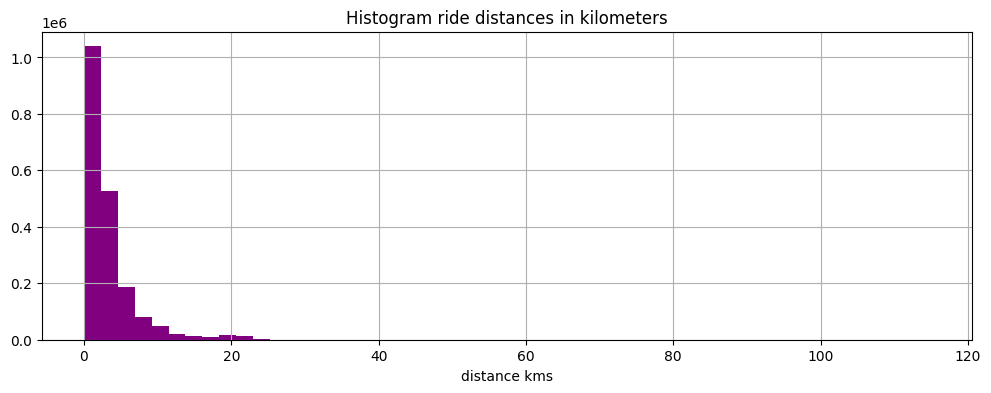

In [ ]:
# add new column to dataframe with distance in kilometers
train.distance.hist(bins=50, figsize=(12,4), color = 'purple')
plt.xlabel('distance kms')
plt.title('Histogram ride distances in kilometers')
train.distance.describe()

In [ ]:
test['distance'].describe()

count    9914.000000
mean        3.435371
std         3.972374
min         0.000000
25%         1.298277
50%         2.217412
75%         4.045302
max        99.996040
Name: distance, dtype: float64

Since the test data has trip distance only upto 100km, we can filter out larger distances from the training data as well.

In [ ]:
train[train['distance']>100].shape[0]

74

In [ ]:
train = train[train['distance']<=100]

In [ ]:
train['fare_per_km'] = np.where(train['distance']<1, train['fare_amount'], train['fare_amount']/train['distance'])

<ipython-input-237-217de0300c81>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['fare_per_km'] = np.where(train['distance']<1, train['fare_amount'], train['fare_amount']/train['distance'])


In [ ]:
train.head()

key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  distance  fare_per_km  
0                1  1.030764     4.365694  
1                1  8.450134     1.999968  
2                2  1.389525     4.102121  
3                1  2.799270     2.750717  
4                1  1.999157     2.651118

**Add Datetime Features**

Segregating the pickup_datetime feature into respective parts: Year, Month, Date, Day, Hour will help us further analyse the impact of these features on the fare:

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1957500 entries, 0 to 1999999
Data columns (total 10 columns):
 #   Column             Dtype              
---  ------             -----              
 0   key                object             
 1   fare_amount        float64            
 2   pickup_datetime    datetime64[ns, UTC]
 3   pickup_longitude   float64            
 4   pickup_latitude    float64            
 5   dropoff_longitude  float64            
 6   dropoff_latitude   float64            
 7   passenger_count    int64              
 8   distance           float64            
 9   fare_per_km        float64            
dtypes: datetime64[ns, UTC](1), float64(7), int64(1), object(1)
memory usage: 164.3+ MB


In [ ]:
data = [train, test]

# Ensure 'pickup_datetime' is in datetime format for both DataFrames
for i, df in enumerate(data):
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    data[i] = df

# Extract year, month, day, day of the week, and hour from 'pickup_datetime' using .loc
for i, df in enumerate(data):
    df.loc[:, 'year'] = df['pickup_datetime'].dt.year
    df.loc[:, 'month'] = df['pickup_datetime'].dt.month
    df.loc[:, 'day'] = df['pickup_datetime'].dt.day
    df.loc[:, 'day_of_week'] = df['pickup_datetime'].dt.dayofweek
    df.loc[:, 'hour'] = df['pickup_datetime'].dt.hour
    data[i] = df

# Assign modified data back to train and test
train, test = data

<ipython-input-240-1f83364bc225>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])


In [ ]:
print(train['month'].unique())

[ 6  1  8  4  3 11 12  9  7  2  5 10]


In [ ]:
test.head()

key           pickup_datetime  pickup_longitude  \
0  2015-01-27 13:08:24.0000002 2015-01-27 13:08:24+00:00        -73.973320   
1  2015-01-27 13:08:24.0000003 2015-01-27 13:08:24+00:00        -73.986862   
2  2011-10-08 11:53:44.0000002 2011-10-08 11:53:44+00:00        -73.982524   
3  2012-12-01 21:12:12.0000002 2012-12-01 21:12:12+00:00        -73.981160   
4  2012-12-01 21:12:12.0000003 2012-12-01 21:12:12+00:00        -73.966046   

   pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  \
0        40.763805         -73.981430         40.743835                1   
1        40.719383         -73.998886         40.739201                1   
2        40.751260         -73.979654         40.746139                1   
3        40.767807         -73.990448         40.751635                1   
4        40.789775         -73.988565         40.744427                1   

   distance  year  month  day  day_of_week  hour  
0  2.323260  2015      1   27            1    13  
1  2.425353  2015      1   27            1    13  
2  0.618628  2011     10    8            5    11  
3  1.961033  2012     12    1            5    21  
4  5.387301  2012     12    1            5    21

In [ ]:
train.head()

key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  distance  fare_per_km  year  month  day  day_of_week  hour  
0                1  1.030764     4.365694  2009      6   15            0    17  
1                1  8.450134     1.999968  2010      1    5            1    16  
2                2  1.389525     4.102121  2011      8   18            3     0  
3                1  2.799270     2.750717  2012      4   21            5     4  
4                1  1.999157     2.651118  2010      3    9            1     7

In [ ]:
train[['year','month','day','day_of_week','hour']].describe()

year         month           day   day_of_week          hour
count  1.957500e+06  1.957500e+06  1.957500e+06  1.957500e+06  1.957500e+06
mean   2.011737e+03  6.269405e+00  1.570583e+01  3.041263e+00  1.350852e+01
std    1.863391e+00  3.438018e+00  8.682292e+00  1.949925e+00  6.514059e+00
min    2.009000e+03  1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00
25%    2.010000e+03  3.000000e+00  8.000000e+00  1.000000e+00  9.000000e+00
50%    2.012000e+03  6.000000e+00  1.600000e+01  3.000000e+00  1.400000e+01
75%    2.013000e+03  9.000000e+00  2.300000e+01  5.000000e+00  1.900000e+01
max    2.015000e+03  1.200000e+01  3.100000e+01  6.000000e+00  2.300000e+01

In [ ]:
dayofweek_mapping = {
    0:'Monday',
    1:'Tuesday',
    2:'Wednesday',
    3:'Thursday',
    4:'Friday',
    5:'Saturday',
    6:'Sunday'
}

train['day_of_week'] = train['day_of_week'].replace(dayofweek_mapping)
test['day_of_week'] = test['day_of_week'].replace(dayofweek_mapping)

In [ ]:
# Month mapping from numbers to abbreviations
month_mapping = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
}

# Replace numerical months with abbreviated month names in both train and test DataFrames
train['month'] = train['month'].map(month_mapping)
test['month'] = test['month'].map(month_mapping)


In [ ]:
train.head()

key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  distance  fare_per_km  year month  day day_of_week  hour  
0                1  1.030764     4.365694  2009   Jun   15      Monday    17  
1                1  8.450134     1.999968  2010   Jan    5     Tuesday    16  
2                2  1.389525     4.102121  2011   Aug   18    Thursday     0  
3                1  2.799270     2.750717  2012   Apr   21    Saturday     4  
4                1  1.999157     2.651118  2010   Mar    9     Tuesday     7

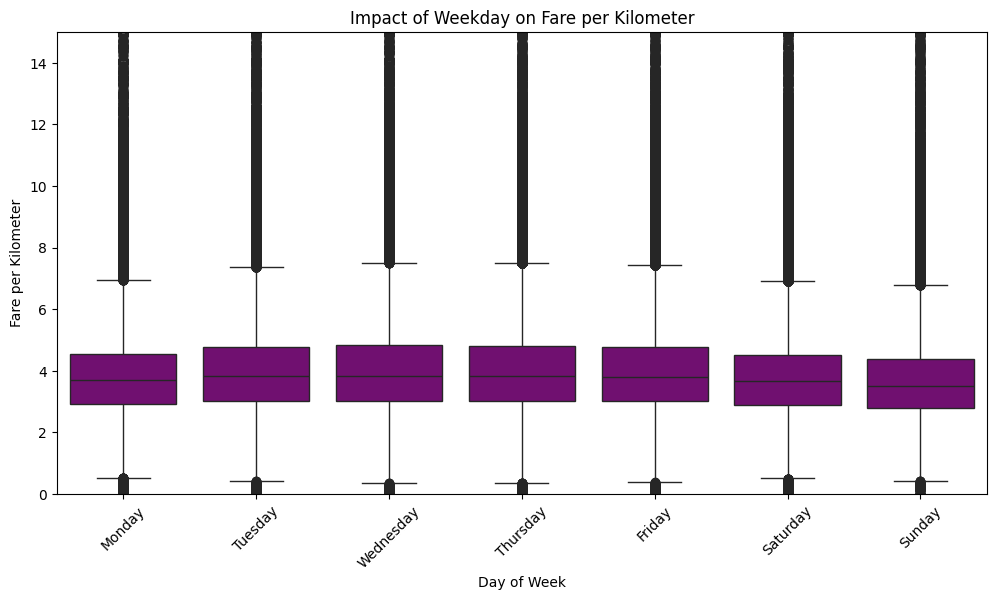

In [ ]:
# Define the category order for the days of the week
category_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Set the order of the categories in the 'day_of_week' column
train['day_of_week'] = pd.Categorical(train['day_of_week'], categories=category_order, ordered=True)

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=train, x='day_of_week', y='fare_per_km', order=category_order, color = 'purple')
plt.title('Impact of Weekday on Fare per Kilometer')
plt.ylim(0, 15)
plt.xlabel('Day of Week')
plt.ylabel('Fare per Kilometer')
plt.xticks(rotation=45)
plt.show()

Fares on Saturday, Sunday and Monday seem to be slightly lower that other days - but overall there's not much of an impact.

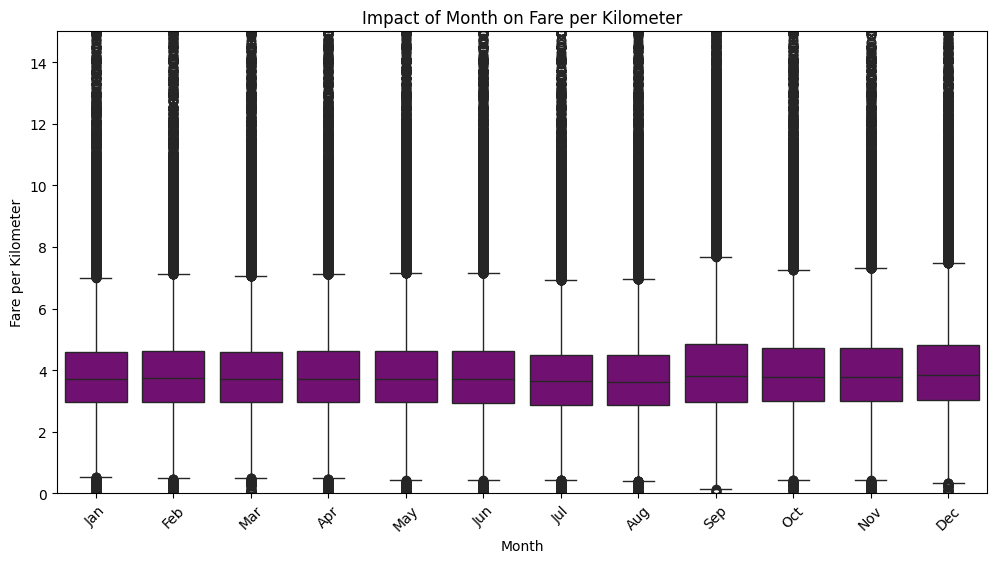

In [ ]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Set the order of the categories in the 'month' column
train['month'] = pd.Categorical(train['month'], categories=month_order, ordered=True)

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=train, x='month', y='fare_per_km', order=month_order, color = 'purple')
plt.title('Impact of Month on Fare per Kilometer')
plt.ylim(0, 15)
plt.xlabel('Month')
plt.ylabel('Fare per Kilometer')
plt.xticks(rotation=45)
plt.show()

Months do not seem to have any sizeable impact on the fare

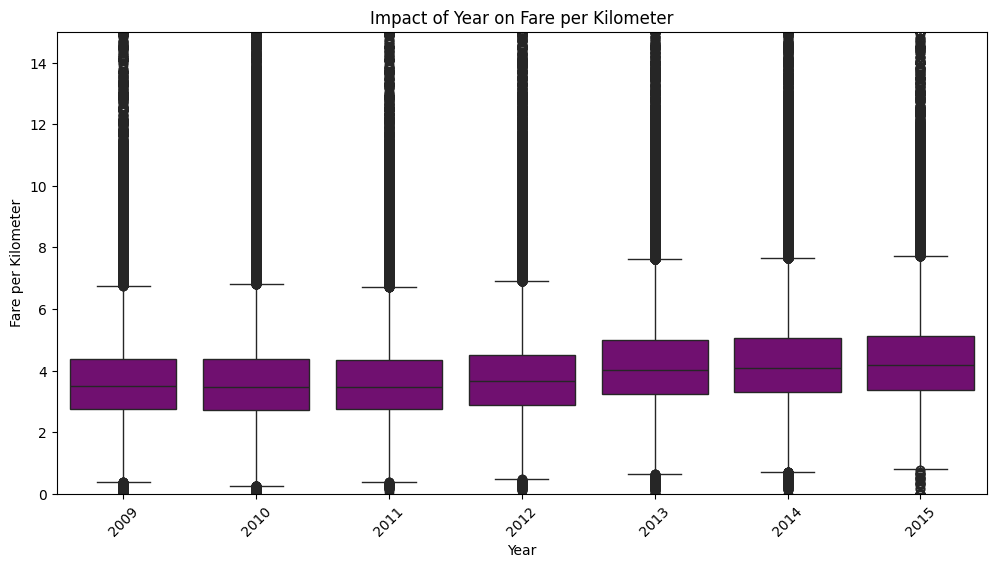

In [ ]:
# Define the category order for the years
years = sorted(train['year'].unique())

# Ensure 'year' is treated as a categorical variable with ordered categories
train['year'] = pd.Categorical(train['year'], categories=years, ordered=True)

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=train, x='year', y='fare_per_km', order=years, color = 'purple')
plt.title('Impact of Year on Fare per Kilometer')
plt.ylim(0, 15)
plt.xlabel('Year')
plt.ylabel('Fare per Kilometer')
plt.xticks(rotation=45)
plt.show()

The mean fare seems to be incresing with each year. This could be attributed to inflation and the general increase in prices of goods and services year on year.

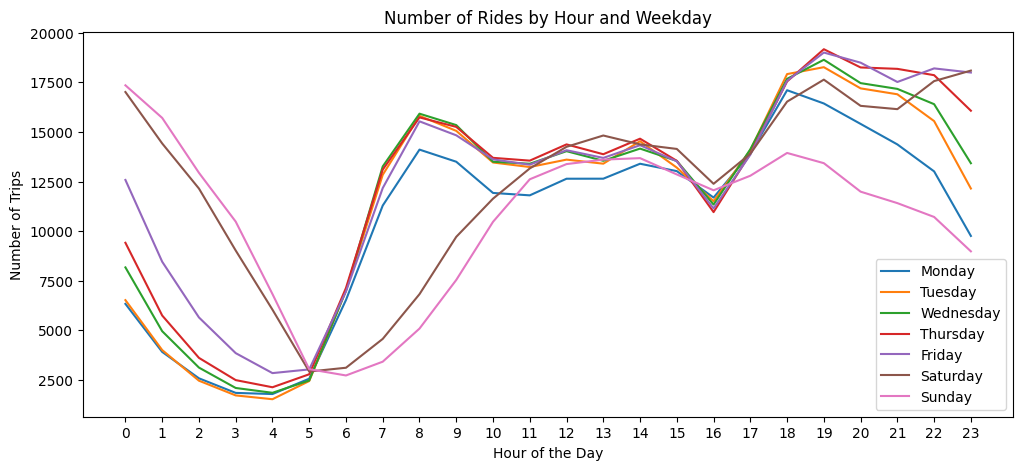

In [ ]:
#Busiest hours of the day

data = pd.pivot_table(train, values = 'key', index = 'hour', columns='day_of_week', aggfunc='count')
plt.rcParams['figure.figsize'] = (12,5)
ax = data.plot(kind='line')
ax.set_title('Number of Rides by Hour and Weekday')
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Number of Trips')
ax.set_xticks(np.arange(0,24,1))

order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[handles[labels.index(x)] for x in order], labels=order)

plt.show()

7am to 9am in the morning (except on saturday and sunday) and 6pm to 10pm in the evening (except on Sunday) seem to be the busiest hours of the day
Friday and Saturday nights are busier than other days of the week

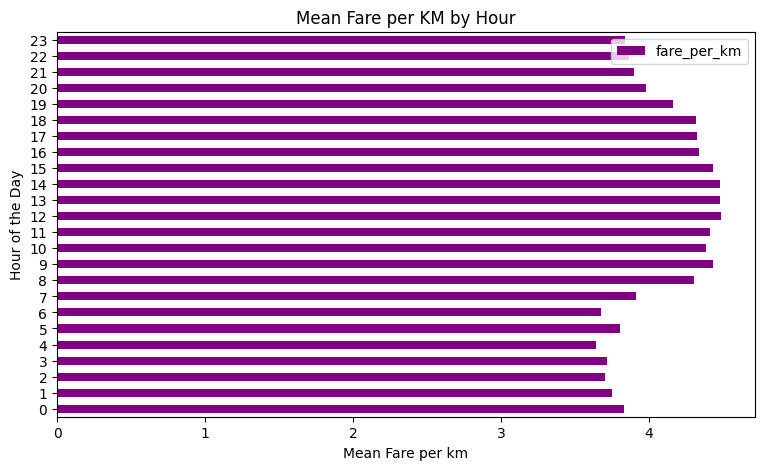

In [ ]:
#  Relationship between hour of the day and fare/km

data = pd.DataFrame(train.groupby('hour').mean(numeric_only=True)['fare_per_km'])

plt.rcParams['figure.figsize'] = (9,5)
data.plot(kind='barh', color = 'purple')
plt.xlabel('Mean Fare per km')
plt.ylabel('Hour of the Day')
plt.title('Mean Fare per KM by Hour')

plt.show()

fare/km is higher between 8 am to 7 pm than other times of the day. This could be because of working hours.
So will this be true for all days of the week?

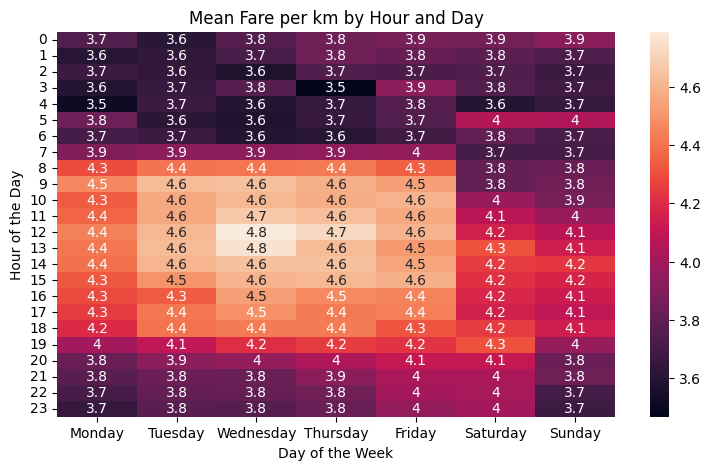

In [ ]:
# Relationship between fare/km and hour/day

column_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.rcParams['figure.figsize'] = (9,5)
data = pd.pivot_table(train, values = 'fare_per_km', index = 'hour', columns='day_of_week', aggfunc='mean').reindex(columns=column_order)
sns.heatmap(data, annot=True)
plt.title('Mean Fare per km by Hour and Day')
plt.ylabel('Hour of the Day')
plt.xlabel('Day of the Week')
plt.show()

* The increase in fare/km during working hours (8 am to 7 pm) holds true only for weekdays.

* Friday and saturday evenings (6 pm to 10 pm) also show a spike in fare/km
After analysis of hour and weekday, we see that the fare per km is significantly higher during working hours on weekdays.

We can add a feature signifying weather the timing of the ride falls within these hours:

In [ ]:
#Adding Office Hours as a Feature
train['office_hours'] = np.where((train['hour']>=8) &
                                    (train['hour']<=18) &
                                    (~train['day_of_week'].isin(['Saturday', 'Sunday'])), 1, 0)

In [ ]:
test['office_hours'] = np.where((test['hour']>=8) &
                                    (test['hour']<=18) &
                                    (~test['day_of_week'].isin(['Saturday', 'Sunday'])), 1, 0)

Since the month and date don't have any impact on the fare_amount, we can drop these features from the train and test dataset

In [ ]:
train.drop(['day', 'month'], axis=1, inplace=True)
test.drop(['day', 'month'], axis=1, inplace=True)

**Add Clusters for Pickup and Drop**

Lets start by visualising the spread of pickup and drop points across the city:

In [ ]:
# Visualise the geographical spread of pickup and dropoff coordinates

lon_list = list(train['pickup_longitude']) + list(train['dropoff_longitude'])
lat_list = list(train['pickup_latitude']) + list(train['dropoff_latitude'])

lon_lat_data = {'longitude':lon_list, 'latitude':lat_list}

lon_lat_df = pd.DataFrame(lon_lat_data)

lon_lat_df.head()

longitude   latitude
0 -73.844311  40.721319
1 -74.016048  40.711303
2 -73.982738  40.761270
3 -73.987130  40.733143
4 -73.968095  40.768008

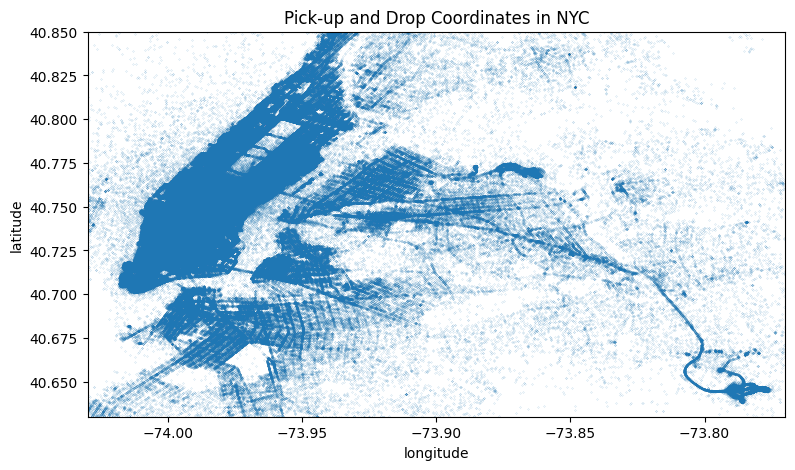

In [ ]:
ny_lat_border = [40.63, 40.85]
ny_lon_border = [-74.03, -73.77]
plt.rcParams['figure.figsize'] = (9,5)

lon_lat_df.plot(kind='scatter', x = 'longitude', y = 'latitude', alpha=0.6, s=0.02)
plt.title('Pick-up and Drop Coordinates in NYC')
plt.ylim(ny_lat_border)
plt.xlim(ny_lon_border)

plt.show()

Other than the 5 boroughs of NYC (Manhattan, Bronx, Queens, Brooklyn and staten island), we also need to further divide Manhattan into major clusters. We'll use KMeans clustering algorithm to divide the city into 15 clulsters

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
# Clustering of coordinates using Kmeans
nyc_clusters = KMeans(n_clusters=15, random_state=42, n_init=10).fit(lon_lat_df)
lon_lat_df['cluster'] = nyc_clusters.labels_

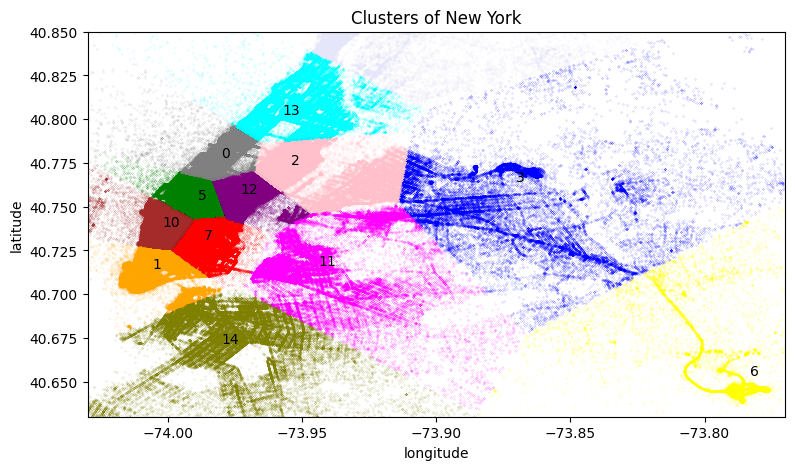

In [ ]:
plt.rcParams['figure.figsize'] = (9,5)
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow', 'teal', 'lavender', 'maroon']
clusters = list(lon_lat_df.cluster.unique())

fig, ax = plt.subplots()
for cluster, color in zip(clusters, colors):
  cluster_data = lon_lat_df[lon_lat_df['cluster']==cluster]
  cluster_data.plot(kind='scatter', x = 'longitude', y = 'latitude',alpha=0.6, s=0.02, color=color, ax=ax)

  centroid_lon = cluster_data['longitude'].mean()
  centroid_lat = cluster_data['latitude'].mean()
  ax.annotate(f'{cluster}', (centroid_lon, centroid_lat), fontsize=10, color='black')

plt.ylim(ny_lat_border)
plt.xlim(ny_lon_border)
plt.title('Clusters of New York')
plt.show()

Here, we see manhattan divided into its major neighbourhoods

In case the Kmeans algorithm is run again, the numbering of the clusters might change.

In [ ]:
def add_clusters(x):

  #To add pickup cluster and drop cluster as features to input dataframe(x)
  x2 = x[['pickup_longitude', 'pickup_latitude']].rename(columns={'pickup_longitude':'longitude', 'pickup_latitude':'latitude'}).astype(float)
  x3 = x[['dropoff_longitude', 'dropoff_latitude']].rename(columns={'dropoff_longitude':'longitude', 'dropoff_latitude':'latitude'}).astype(float)
  x['pick_cluster'] = nyc_clusters.predict(x2)
  x['drop_cluster'] = nyc_clusters.predict(x3)

In [ ]:
add_clusters(train)
add_clusters(test)

In [ ]:
train[['pick_cluster', 'drop_cluster']].describe()

pick_cluster  drop_cluster
count  1.957500e+06  1.957500e+06
mean   6.438613e+00  6.635116e+00
std    4.322156e+00  4.462201e+00
min    0.000000e+00  0.000000e+00
25%    2.000000e+00  2.000000e+00
50%    6.000000e+00  7.000000e+00
75%    1.000000e+01  1.200000e+01
max    1.400000e+01  1.400000e+01

In [ ]:
train.head()

key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  distance  fare_per_km  year day_of_week  hour  \
0                1  1.030764     4.365694  2009      Monday    17   
1                1  8.450134     1.999968  2010     Tuesday    16   
2                2  1.389525     4.102121  2011    Thursday     0   
3                1  2.799270     2.750717  2012    Saturday     4   
4                1  1.999157     2.651118  2010     Tuesday     7   

   office_hours  pick_cluster  drop_cluster  
0             1             3             3  
1             1             1             0  
2             0             5             5  
3             0             7             5  
4             0            12             2

So I remembered trips from airports are fixed fee. I don't know why, probably the entrance fee adds up or maybe they just scam tourists. So that I wanted to check if it is actually true.

In [ ]:
#JFK airport
jfk = (-73.7822222222, 40.6441666667)
#Newark Liberty International Airport
ewr = (-74.175, 40.69)
#LaGuardia Airport
lgr = (-73.87, 40.77)

def is_near_airport(pickup_lon, pickup_lat, dropoff_lon, dropoff_lat, radius=2):
    airports = [jfk, ewr, lgr]
    for airport in airports:
        airport_lon, airport_lat = airport
        if (haversine(pickup_lon, pickup_lat, airport_lon, airport_lat) <= radius or
            haversine(dropoff_lon, dropoff_lat, airport_lon, airport_lat) <= radius):
            return True
    return False

In [ ]:
train['is_airport_trip'] = train.apply(lambda row: is_near_airport(row['pickup_longitude'], row['pickup_latitude'], row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

In [ ]:
train.head()

key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  distance  fare_per_km  year day_of_week  hour  \
0                1  1.030764     4.365694  2009      Monday    17   
1                1  8.450134     1.999968  2010     Tuesday    16   
2                2  1.389525     4.102121  2011    Thursday     0   
3                1  2.799270     2.750717  2012    Saturday     4   
4                1  1.999157     2.651118  2010     Tuesday     7   

   office_hours  pick_cluster  drop_cluster  is_airport_trip  
0             1             3             3            False  
1             1             1             0            False  
2             0             5             5            False  
3             0             7             5            False  
4             0            12             2            False

In [ ]:
# Count the number of trips that are airport trips
num_airport_trips = train['is_airport_trip'].sum()

# Count the total number of trips
total_trips = len(train)

print(f"Number of airport trips: {num_airport_trips}")
print(f"Total number of trips: {total_trips}")

Number of airport trips: 108830
Total number of trips: 1957500


In [ ]:
# Calculate the average fare for airport trips
average_fare_airport = train[train['is_airport_trip']]['fare_amount'].mean()

# Calculate the average fare for non-airport trips
average_fare_non_airport = train[~train['is_airport_trip']]['fare_amount'].mean()

# Display the average fares
print(f"Average fare for airport trips: {average_fare_airport}")
print(f"Average fare for non-airport trips: {average_fare_non_airport}")

Average fare for airport trips: 37.230576127905906
Average fare for non-airport trips: 9.803957872416387


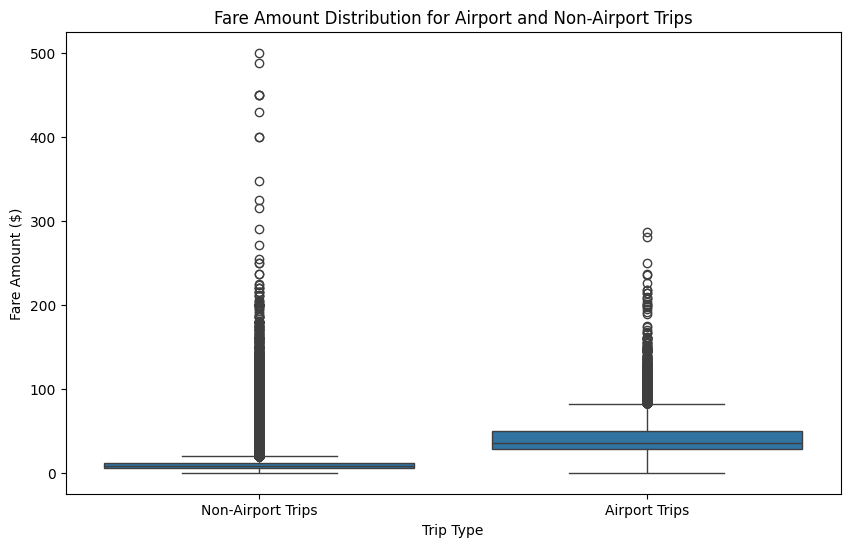

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_airport_trip', y='fare_amount', data=train)
plt.xticks([0, 1], ['Non-Airport Trips', 'Airport Trips'])
plt.title('Fare Amount Distribution for Airport and Non-Airport Trips')
plt.xlabel('Trip Type')
plt.ylabel('Fare Amount ($)')
plt.show()

In [ ]:
#Making dataframe with no airport trips
train_no_airport = train[train['is_airport_trip'] == False].copy()
train_no_airport.drop(columns=['is_airport_trip'], inplace=True)
train_no_airport.shape

(1848670, 16)

In [ ]:
train.shape

(1957500, 17)

###**Summary of EDA:**

* First, I checked the dataset's data types. All columns were of type float64 and int64 except for the 'key' column, which was datetime. Out of 2 million rows, 14 rows had empty dropoff values, so I removed them.

* To train the model effectively, I used the minimum and maximum bounding box of the test set and filtered out trips in the training dataset that exceeded these borders.

* I plotted the data points on a map, which showed dense clustering at certain points. However, a few trip data points were located on water, which is impossible. Using a mask, I removed those values.

* Additionally, I needed the distance of each trip in kilometers, so I used the Haversine formula to calculate the distance of each trip.

* For the test data, the maximum trip distance was 99 km, so I removed any trip over 100 km in the training set.

* Next, I split the datetime column into separate columns to analyze how hour, day, month, and year affect taxi fare. It turned out that day and month didn't have a significant impact, but the fare increased throughout the year. The taxi fare was also higher from 9 AM to 7 PM, which are office hours, so I added a new column to indicate if it was during office hours or not. The day and month columns were dropped as they were not important.

* Then, I created a dataset with longitude and latitude using the training set to check clustering. I split it into 15 clusters and added a column to indicate which cluster each trip falls into.

* I also recognized that there were three airports in the area during that time. Since trips picked up from airports often have a fixed fare, I checked if each trip was within a 2 km radius of these airports and added a new column to indicate if it was an airport trip. Eventually, I deleted this column because it helped improve the RMSE score.





**Dataset preparation for model**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_data, val_data = train_test_split(train, test_size=0.2, random_state=42)

In [ ]:
train_data_noairport, val_data_noairport = train_test_split(train_no_airport, test_size=0.2, random_state=42)

In [ ]:
len(train_data), len(val_data)

(1566000, 391500)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1566000 entries, 302206 to 124641
Data columns (total 17 columns):
 #   Column             Non-Null Count    Dtype              
---  ------             --------------    -----              
 0   key                1566000 non-null  object             
 1   fare_amount        1566000 non-null  float64            
 2   pickup_datetime    1566000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   1566000 non-null  float64            
 4   pickup_latitude    1566000 non-null  float64            
 5   dropoff_longitude  1566000 non-null  float64            
 6   dropoff_latitude   1566000 non-null  float64            
 7   passenger_count    1566000 non-null  int64              
 8   distance           1566000 non-null  float64            
 9   fare_per_km        1566000 non-null  float64            
 10  year               1566000 non-null  category           
 11  day_of_week        1566000 non-null  category           
 12  hour           

In order to test if airport trips make difference, I am making two dataframes, If it does affect I will remove all airport trips. yeah

In [ ]:
train_data[['office_hours', 'pick_cluster', 'drop_cluster', 'day_of_week', 'is_airport_trip']] = train_data[['office_hours', 'pick_cluster', 'drop_cluster', 'day_of_week', 'is_airport_trip']].astype('category')
val_data[['office_hours', 'pick_cluster', 'drop_cluster', 'day_of_week', 'is_airport_trip']] = val_data[['office_hours', 'pick_cluster', 'drop_cluster', 'day_of_week','is_airport_trip']].astype('category')
train_data_noairport[['office_hours', 'pick_cluster', 'drop_cluster', 'day_of_week']] = train_data_noairport[['office_hours', 'pick_cluster', 'drop_cluster', 'day_of_week']].astype('category')
val_data_noairport[['office_hours', 'pick_cluster', 'drop_cluster', 'day_of_week']] = val_data_noairport[['office_hours', 'pick_cluster', 'drop_cluster', 'day_of_week']].astype('category')


#**Training**

##**Baseline Model - Linear Regression**

We'll try our baseline linear regression model with minimal features. This will help us understand if the features we have added are helpful.

In [ ]:
train.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'distance', 'fare_per_km', 'year', 'day_of_week',
       'hour', 'office_hours', 'pick_cluster', 'drop_cluster',
       'is_airport_trip'],
      dtype='object')

In [ ]:
#I am going to use original features here
input_cols_with_airport = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'is_airport_trip']
target_col = 'fare_amount'
input_cols_no_airport = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']


In [ ]:
# I wanted to check if airport trips affect the fare so I created dataset without airport trips
lr1_AP_train_x = train_data_noairport[input_cols_no_airport].copy()
lr1_AP_val_x = val_data_noairport[input_cols_no_airport].copy()
lr1_AP_train_y = train_data_noairport[target_col].copy()
lr1_AP_val_y = val_data_noairport[target_col].copy()

In [ ]:
# With airport
lr1_train_x = train_data[input_cols_with_airport].copy()
lr1_val_x = val_data[input_cols_with_airport].copy()
lr1_train_y = train_data[target_col].copy()
lr1_val_y = val_data[target_col].copy()

In [ ]:
# Scale Numerical Values to (0,1) range using MinMaxScaler
scaler_with_airport = MinMaxScaler()
scaler_no_airport = MinMaxScaler()

scaler_with_airport.fit(lr1_train_x[input_cols_with_airport])
lr1_train_x[input_cols_with_airport] = scaler_with_airport.transform(lr1_train_x[input_cols_with_airport])
lr1_val_x[input_cols_with_airport] = scaler_with_airport.transform(lr1_val_x[input_cols_with_airport])

scaler_no_airport.fit(lr1_AP_train_x[input_cols_no_airport])
lr1_AP_train_x[input_cols_no_airport] = scaler_no_airport.transform(lr1_AP_train_x[input_cols_no_airport])
lr1_AP_val_x[input_cols_no_airport] = scaler_no_airport.transform(lr1_AP_val_x[input_cols_no_airport])

In [ ]:
#Check the range of all the input columns
lr1_train_x.describe().loc[['min','max']]

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
min               0.0              0.0                0.0               0.0   
max               1.0              1.0                1.0               1.0   

     passenger_count  is_airport_trip  
min              0.0              0.0  
max              1.0              1.0

In [ ]:
lr1_AP_train_x.describe().loc[['min','max']]

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
min               0.0              0.0                0.0               0.0   
max               1.0              1.0                1.0               1.0   

     passenger_count  
min              0.0  
max              1.0

In [ ]:
#Train a Linear Regression Model
from sklearn.linear_model import LinearRegression
lr1_model = LinearRegression().fit(lr1_train_x, lr1_train_y)

#Generate Predictions on training and validation data
lr1_pred_train = lr1_model.predict(lr1_train_x)
lr1_pred_val = lr1_model.predict(lr1_val_x)

#Compute training and validation loss
lr1_train_rmse = mean_squared_error(lr1_train_y, lr1_pred_train, squared=False)
lr1_val_rmse = mean_squared_error(lr1_val_y, lr1_pred_val, squared=False)

print(f'The RMSE loss for the training set is $ {lr1_train_rmse}')
print(f'The RMSE loss for the validation set is $ {lr1_val_rmse}')

The RMSE loss for the training set is $ 7.288356320698141
The RMSE loss for the validation set is $ 7.255574791524604


In [ ]:
#Train a Linear Regression Model
from sklearn.linear_model import LinearRegression
lr_model_AP = LinearRegression().fit(lr1_AP_train_x, lr1_AP_train_y)

#Generate Predictions on training and validation data
lr1_pred_train_AP = lr_model_AP.predict(lr1_AP_train_x)
lr1_pred_val_AP = lr_model_AP.predict(lr1_AP_val_x)

#Compute training and validation loss
lr1_train_rmse_AP = mean_squared_error(lr1_AP_train_y, lr1_pred_train_AP, squared=False)
lr1_val_rmse_AP = mean_squared_error(lr1_AP_val_y, lr1_pred_val_AP, squared=False)

print(f'The RMSE loss for the training set with no airport trips is $ {lr1_train_rmse_AP}')
print(f'The RMSE loss for the validation set with no airport trips is $ {lr1_val_rmse_AP}')

The RMSE loss for the training set with no airport trips is $ 6.371451830231842
The RMSE loss for the validation set with no airport trips is $ 6.423566605795534


It is clear that removing Airport Trip is very useful. So i will use dataframe with no Airports trip.

In [ ]:
train = train_no_airport

In [ ]:
train_data, val_data  = train_data_noairport, val_data_noairport

The Root Mean Squared Error(RMSE) for our base model is approximately 6.4

##**Ridge Regression with Additional Features**
Identifying input and target columns:

In [ ]:
input_cols = ['pickup_longitude',
              'pickup_latitude',
              'dropoff_longitude',
              'dropoff_latitude',
              'passenger_count',
              'distance',
              'year',
              'day_of_week',
              'hour',
              'office_hours',
              'pick_cluster',
              'drop_cluster']
target_col = 'fare_amount'

In [ ]:
#Prepare test and validation data:
lr2_train_x = train_data[input_cols].copy()
lr2_val_x = val_data[input_cols].copy()
lr2_train_y = train_data[target_col].copy()
lr2_val_y = val_data[target_col].copy()

In [ ]:
#Identify Numeric and categorical columns
numeric_cols = list(lr2_train_x.select_dtypes(exclude=['category']).columns)
categorical_cols = list(lr2_train_x.select_dtypes(include=['category']).columns)

print('Numeric Columns: ', numeric_cols)
print('Categorical Columns: ', categorical_cols)

Numeric Columns:  ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'distance', 'hour']
Categorical Columns:  ['year', 'day_of_week', 'office_hours', 'pick_cluster', 'drop_cluster']


In [ ]:
#Scale numeric columns to (0,1) range:

scaler = MinMaxScaler()
scaler.fit(train[numeric_cols])

MinMaxScaler()

In [ ]:
lr2_train_x.loc[:,numeric_cols] = scaler.transform(lr2_train_x.loc[:,numeric_cols])
lr2_val_x.loc[:,numeric_cols] = scaler.transform(lr2_val_x.loc[:,numeric_cols])

In [ ]:
lr2_train_x.describe().loc[['min','max']]

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
min               0.0              0.0                0.0               0.0   
max               1.0              1.0                1.0               1.0   

     passenger_count  distance  hour  
min              0.0       0.0   0.0  
max              1.0       1.0   1.0

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder.fit(train[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
lr2_train_x[encoded_cols] = encoder.transform(lr2_train_x[categorical_cols])
lr2_val_x[encoded_cols] = encoder.transform(lr2_val_x[categorical_cols])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
#Train a ridge regression model:
from sklearn.linear_model import Ridge
lr2_model = Ridge()
lr2_model.fit(lr2_train_x[numeric_cols + encoded_cols], lr2_train_y)

Ridge()

In [ ]:
lr2_pred_train = lr2_model.predict(lr2_train_x[numeric_cols + encoded_cols])
lr2_pred_val = lr2_model.predict(lr2_val_x[numeric_cols + encoded_cols])

In [ ]:
lr2_train_rmse = mean_squared_error(lr2_train_y, lr2_pred_train, squared=False)
lr2_val_rmse = mean_squared_error(lr2_val_y, lr2_pred_val, squared=False)

print(f'The RMSE loss for the training set is $ {lr2_train_rmse}')
print(f'The RMSE loss for the validation set is $ {lr2_val_rmse}')


The RMSE loss for the training set is $ 4.429096966836408
The RMSE loss for the validation set is $ 4.518334102631522


The Ridge regression model is off by $4.4 which is much better than our baseline model RMSE of 6.4.

##**Random Forest:**

Since we have already scaled numeric features/encoded categorical features for the previous model, we will use them as the standard datasets for training, validation and testing for all future models:

In [ ]:
# Standardising the training, validation and test data for all models

train_x = lr2_train_x[numeric_cols + encoded_cols].copy()
val_x = lr2_val_x[numeric_cols + encoded_cols].copy()
train_y = train_data[target_col].copy()
val_y = val_data[target_col].copy()


In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
#Now we'll see how a basic random forest model performs on our data without any hyperparameter tuning:

#Train a RandomForestRegressor Model
rf1_model = RandomForestRegressor(max_depth=10, n_jobs=-1, n_estimators=100, min_samples_leaf=5, max_features=0.5, random_state=42)
rf1_model.fit(train_x, train_y)

RandomForestRegressor(max_depth=10, max_features=0.5, min_samples_leaf=5,
                      n_jobs=-1, random_state=42)

OMG this took so long, I had to work on gaming pc on G4 and use TPU v2 to run this. NICE!

In [ ]:
#Make predictions on train and validation data - calculate RMSE
rf1_pred_train = rf1_model.predict(train_x)
rf1_pred_val = rf1_model.predict(val_x)
rf1_train_rmse = mean_squared_error(train_y, rf1_pred_train, squared=False)
rf1_val_rmse = mean_squared_error(val_y, rf1_pred_val, squared=False)
print(f'The RMSE loss for the training set is $ {rf1_train_rmse}')
print(f'The RMSE loss for the validation set is $ {rf1_val_rmse}')

The RMSE loss for the training set is $ 3.600426857743122
The RMSE loss for the validation set is $ 3.7497806363790347


###**Hyperparameter Tuning with Random Forest**

In [ ]:
sub_train_x = train_x.sample(frac=0.15, random_state=42)
sub_val_x = val_x.sample(frac=0.15, random_state=42)
sub_train_y = train_y.sample(frac=0.15, random_state=42)
sub_val_y = val_y.sample(frac=0.15, random_state=42)
sub_test = test.sample(frac=0.15, random_state=42)


**Finetuning part:**

In [ ]:
def test_params(**params):
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params).fit(sub_train_x, sub_train_y)
    train_rmse = mean_squared_error(model.predict(sub_train_x), sub_train_y, squared=False)
    val_rmse = mean_squared_error(model.predict(sub_val_x), sub_val_y, squared=False)
    return train_rmse, val_rmse

In [ ]:
def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], []
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_params(**params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

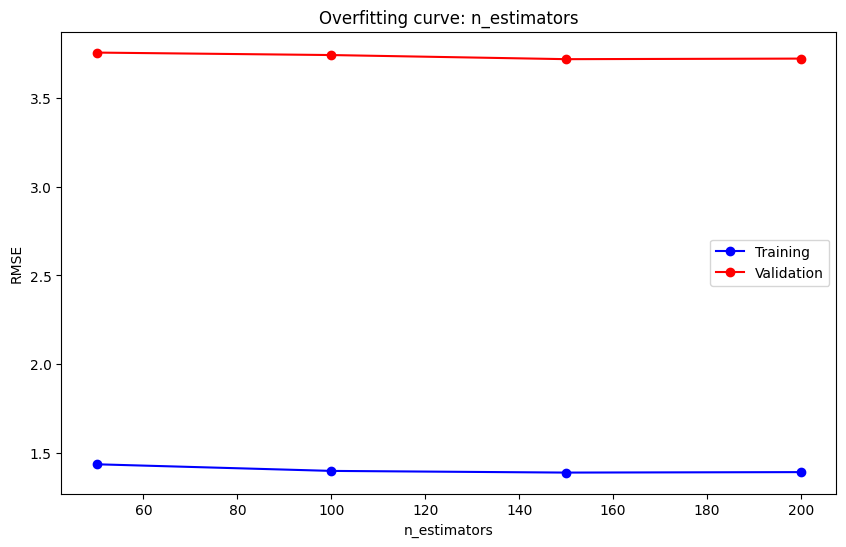

In [ ]:
test_param_and_plot('n_estimators', [50, 100, 150, 200])

he validation error for number of decision tress (n_estimators) seems to be increasing beyond 50

In [ ]:
test_param_and_plot('max_depth', [10, 15, 20, 25])

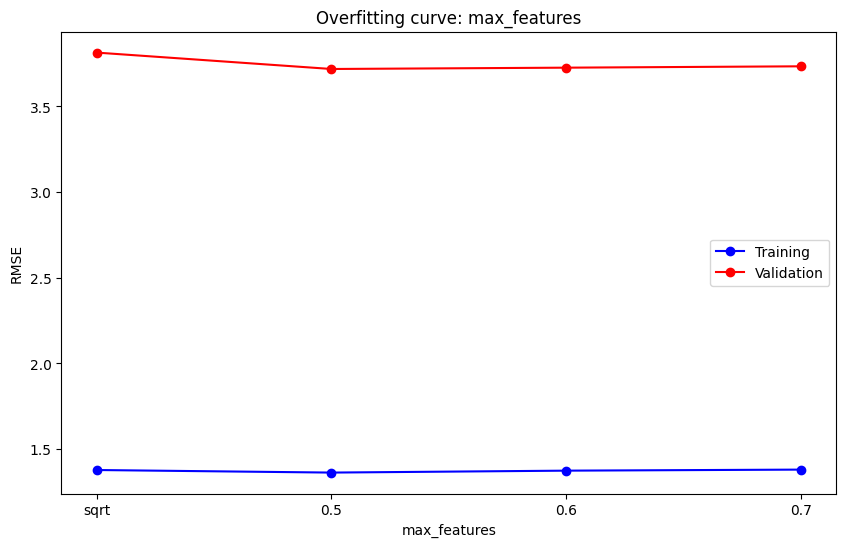

In [ ]:
test_param_and_plot('max_features', ['sqrt', 0.5, 0.6, 0.7])

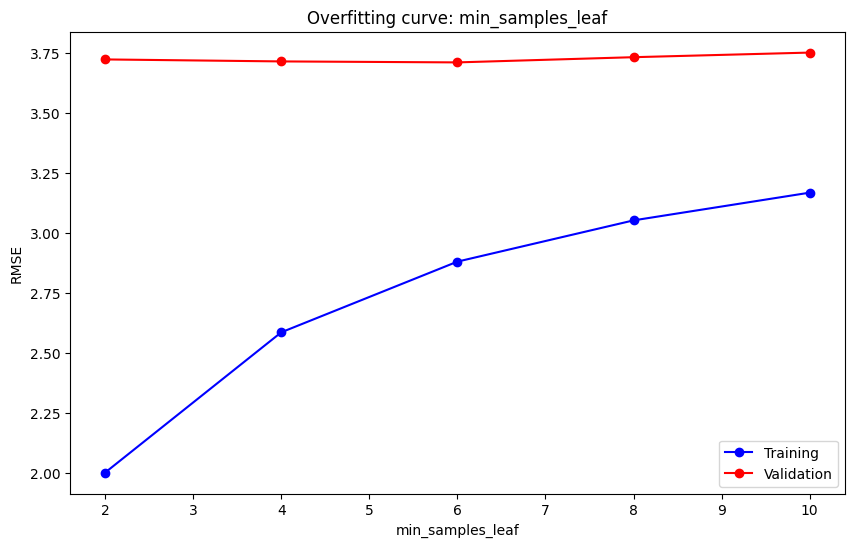

In [ ]:
test_param_and_plot('min_samples_leaf', [2, 4, 6, 8, 10])

In [ ]:
test_params(n_estimators = 100, max_depth=20, min_samples_leaf=4, max_features=0.5)

(2.8635868524530426, 3.738398550863182)

In [ ]:
rf2_model = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators = 100, max_depth=20, min_samples_leaf=4, max_features=0.5)
rf2_model.fit(train_x, train_y)

RandomForestRegressor(max_depth=20, max_features=0.5, min_samples_leaf=4,
                      n_jobs=-1, random_state=42)

In [ ]:
rf2_pred_train = rf2_model.predict(train_x)
rf2_pred_val = rf2_model.predict(val_x)
rf2_train_rmse = mean_squared_error(train_y, rf2_pred_train, squared=False)
rf2_val_rmse = mean_squared_error(val_y, rf2_pred_val, squared=False)
print(f'The RMSE loss for the training set is $ {rf2_train_rmse}')
print(f'The RMSE loss for the validation set is $ {rf2_val_rmse}')

The RMSE loss for the training set is $ 3.0301959860941365
The RMSE loss for the validation set is $ 3.592164318174511


##**Neural Network**

In [ ]:
def build_model(input_shape):
    model = Sequential()

    # Input layer
    model.add(Dense(128, input_dim=input_shape, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Hidden layers
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    return model

# Build the model
model = build_model(train_x.shape[1])

In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [ ]:
partial_train_x, partial_val_x, partial_train_y, partial_val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [ ]:
history = model.fit(
    partial_train_x, partial_train_y,
    validation_data=(partial_val_x, partial_val_y),
    epochs=100,
    batch_size=512,  # Increased batch size
    callbacks=callbacks
)

Epoch 1/100
2311/2311 [==============================] - 19s 6ms/step - loss: 37.9580 - val_loss: 18.3141 - lr: 0.0010
Epoch 2/100
  21/2311 [..............................] - ETA: 11s - loss: 17.4889

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2311/2311 [==============================] - 13s 6ms/step - loss: 21.5100 - val_loss: 16.6675 - lr: 0.0010
Epoch 3/100
2311/2311 [==============================] - 13s 6ms/step - loss: 20.6401 - val_loss: 16.3426 - lr: 0.0010
Epoch 4/100
2311/2311 [==============================] - 13s 6ms/step - loss: 19.7872 - val_loss: 16.5941 - lr: 0.0010
Epoch 5/100
2311/2311 [==============================] - 13s 6ms/step - loss: 19.2983 - val_loss: 16.0532 - lr: 0.0010
Epoch 6/100
2311/2311 [==============================] - 13s 6ms/step - loss: 18.8763 - val_loss: 15.9534 - lr: 0.0010
Epoch 7/100
2311/2311 [==============================] - 13s 6ms/step - loss: 18.5987 - val_loss: 16.2151 - lr: 0.0010
Epoch 8/100
2311/2311 [==============================] - 13s 6ms/step - loss: 18.2986 - val_loss: 16.6638 - lr: 0.0010
Epoch 9/100
2311/2311 [==============================] - 13s 6ms/step - loss: 18.1140 - val_loss: 15.8723 - lr: 0.0010
Epoch 10/100
2311/2311 [==============================] - 13

In [ ]:
val_predictions = model.predict(val_x)
val_rmse_NN = mean_squared_error(val_y, val_predictions, squared=False)
print(f'Validation RMSE: {val_rmse_NN}')

train_predictions = model.predict(train_x)
train_rmse_NN = mean_squared_error(train_y, train_predictions, squared=False)

11555/11555 [==============================] - 18s 2ms/step
Validation RMSE: 4.033060056227877
46217/46217 [==============================] - 71s 2ms/step
train RMSE: 4.033060056227877


In [ ]:
print(f'train RMSE: {train_rmse_NN}')

train RMSE: 3.957278050582755


##**XGBoost**

In [ ]:
import xgboost as xgb
dtrain = xgb.DMatrix(train_x, label=train_y)
dval = xgb.DMatrix(val_x, label=val_y)

In [ ]:
params = {
    'objective': 'reg:squarederror',
    'max_depth': 8,
    'learning_rate': 0.01,
    'n_estimators': 1000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 0.1,
    'lambda': 1.0,
    'random_state': 0
}

xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    early_stopping_rounds=50,
    evals=[(dval, 'eval')],
    verbose_eval=True
)

#I Removed parts of the output in the PDF so please dont get confused

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:59:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:6.63692
[1]	eval-rmse:6.59463
[2]	eval-rmse:6.55426
[3]	eval-rmse:6.51362
[4]	eval-rmse:6.48654
[5]	eval-rmse:6.46836
[6]	eval-rmse:6.42806
[7]	eval-rmse:6.38897
[8]	eval-rmse:6.34991
[9]	eval-rmse:6.31333
[10]	eval-rmse:6.27530
[11]	eval-rmse:6.23785
[12]	eval-rmse:6.20048
[13]	eval-rmse:6.16401
[14]	eval-rmse:6.14337
[15]	eval-rmse:6.10766
[16]	eval-rmse:6.07302
[17]	eval-rmse:6.06920
[18]	eval-rmse:6.03478
[19]	eval-rmse:6.00217
[20]	eval-rmse:5.96988
[21]	eval-rmse:5.93682
[22]	eval-rmse:5.91950
[23]	eval-rmse:5.89808
[24]	eval-rmse:5.86676
[25]	eval-rmse:5.83452
[26]	eval-rmse:5.80346
[27]	eval-rmse:5.77371
[28]	eval-rmse:5.75326
[29]	eval-rmse:5.72289
[30]	eval-rmse:5.69318
[31]	eval-rmse:5.66429
[32]	eval-rmse:5.63541
[33]	eval-rmse:5.60727
[34]	eval-rmse:5.57923
[35]	eval-rmse:5.55214
[36]	eval-rmse:5.53351
[37]	eval-rmse:5.50647
[38]	eval-rmse:5.47982
[39]	eval-rmse:5.46192
[40]	eval-rmse:5.43597
[41]	eval-rmse:5.41014
[42]	eval-rmse:5.38466
[43]	eval-rmse:5.3603

In [ ]:
val_predictions = xgb_model.predict(dval)

# Calculate RMSE
xgb_rmse = np.sqrt(mean_squared_error(val_y, val_predictions))
print(f'Validation RMSE: {xgb_rmse}')

train_predictions = xgb_model.predict(dtrain)

# Another way of calculating RMSE here!
xgb_train_rmse = np.sqrt(mean_squared_error(train_y, train_predictions))
print(f'Train RMSE: {xgb_train_rmse}')

Validation RMSE: 3.6736438848736674
Train RMSE: 3.059253650173913


In [ ]:
#Tuning XGBoost with optuna
!pip install optuna


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.9 MB/s eta 0:00:00


In [ ]:
import optuna


In [ ]:
# Sample 10% of the data
sample_fraction = 0.1
train_x_sample = train_x.sample(frac=sample_fraction, random_state=0)
train_y_sample = train_y.sample(frac=sample_fraction, random_state=0)

dtrain_sample = xgb.DMatrix(train_x_sample, label=train_y_sample)
dval_sample = xgb.DMatrix(val_x, label=val_y)

In [ ]:
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'n_estimators': 1000,
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-4, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-4, 1.0),
        'random_state': 0
    }

    xgb_model = xgb.train(
        params,
        dtrain_sample,
        num_boost_round=1000,
        early_stopping_rounds=50,
        evals=[(dval_sample, 'eval')],
        verbose_eval=False
    )

    val_predictions = xgb_model.predict(dval_sample)
    rmse = np.sqrt(mean_squared_error(val_y, val_predictions))
    return rmse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print(f'Best trial: {study.best_trial.value}')
print(f'Best parameters: {study.best_trial.params}')

[I 2024-05-24 12:01:34,529] A new study created in memory with name: no-name-49265e82-f797-40d7-ab0d-8b0bb5b68df2
<ipython-input-130-01f853baa9cf>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
<ipython-input-130-01f853baa9cf>:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-130-01f853baa9cf>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 

Best trial: 3.8026886958478223
Best parameters: {'max_depth': 9, 'learning_rate': 0.03344322629471639, 'subsample': 0.5642798972366574, 'colsample_bytree': 0.8030532314027585, 'alpha': 0.0003714015951436173, 'lambda': 0.0002876042855283124}


In [ ]:
dtrain = xgb.DMatrix(train_x, label=train_y)
dval = xgb.DMatrix(val_x, label=val_y)

In [ ]:
best_params = {
    'objective': 'reg:squarederror',
    'max_depth': 8,
    'learning_rate': 0.017741099958591133,
    'subsample': 0.7623935693403131,
    'colsample_bytree': 0.7777441521095811,
    'alpha': 0.34933192587668294,
    'lambda': 0.0002690847719722792,
    'random_state': 0
}

xgb_model2 = xgb.train(
    best_params,
    dtrain,
    num_boost_round=1000,
    early_stopping_rounds=50,
    evals=[(dval, 'eval')],
    verbose_eval=True
)

#I Removed parts of the output in the PDF so please dont get confused

[0]	eval-rmse:6.61443
[1]	eval-rmse:6.53959
[2]	eval-rmse:6.46921
[3]	eval-rmse:6.40017
[4]	eval-rmse:6.35318
[5]	eval-rmse:6.32198
[6]	eval-rmse:6.25437
[7]	eval-rmse:6.18897
[8]	eval-rmse:6.12425
[9]	eval-rmse:6.06456
[10]	eval-rmse:6.00300
[11]	eval-rmse:5.94338
[12]	eval-rmse:5.88439
[13]	eval-rmse:5.82735
[14]	eval-rmse:5.79610
[15]	eval-rmse:5.74105
[16]	eval-rmse:5.68867
[17]	eval-rmse:5.68362
[18]	eval-rmse:5.63182
[19]	eval-rmse:5.58401
[20]	eval-rmse:5.53688
[21]	eval-rmse:5.48879
[22]	eval-rmse:5.46461
[23]	eval-rmse:5.43415
[24]	eval-rmse:5.39086
[25]	eval-rmse:5.34567
[26]	eval-rmse:5.30291
[27]	eval-rmse:5.26253
[28]	eval-rmse:5.23555
[29]	eval-rmse:5.19580
[30]	eval-rmse:5.15692
[31]	eval-rmse:5.11883
[32]	eval-rmse:5.08172
[33]	eval-rmse:5.04640
[34]	eval-rmse:5.01100
[35]	eval-rmse:4.97735
[36]	eval-rmse:4.96129
[37]	eval-rmse:4.92766
[38]	eval-rmse:4.89574
[39]	eval-rmse:4.87513
[40]	eval-rmse:4.84461
[41]	eval-rmse:4.81484
[42]	eval-rmse:4.78571
[43]	eval-rmse:4.7584

In [ ]:
# Predict on the validation set
val_predictions2 = xgb_model2.predict(dval)

# Calculate RMSE
rmse_op_xgb = np.sqrt(mean_squared_error(val_y, val_predictions2))
print(f'Validation RMSE: {rmse_op_xgb}')

train_predictions2 = xgb_model2.predict(dtrain)

# Calculate RMSE
xgb_train_rmse_op = np.sqrt(mean_squared_error(train_y, train_predictions2))
print(f'Train RMSE: {xgb_train_rmse_op}')

Validation RMSE: 3.6736438848736674
Train RMSE: 3.059253650173913


In [ ]:
rmse = {
    'Algorithms': ['Linear Regression with AP', 'Linear Regression without AP', 'Ridge regression', 'Random Forest', 'Fine-tuned Random Forest', 'Neural Network', 'XGBoost', 'XGBoost after optuna'],
    'Train RMSE': [lr1_train_rmse_AP,lr1_train_rmse, lr2_train_rmse,rf1_train_rmse, rf2_train_rmse, train_rmse_NN, xgb_train_rmse, xgb_train_rmse_op],
    'Test RMSE': [lr1_val_rmse_AP, lr1_val_rmse, lr2_val_rmse, rf1_val_rmse,rf2_val_rmse, val_rmse_NN, xgb_rmse ,rmse_op_xgb],
}
rmse_df = pd.DataFrame(rmse)


In [ ]:
rmse_melted = rmse_df.melt(id_vars='Algorithms', var_name='Data Set used', value_name='RMSE')

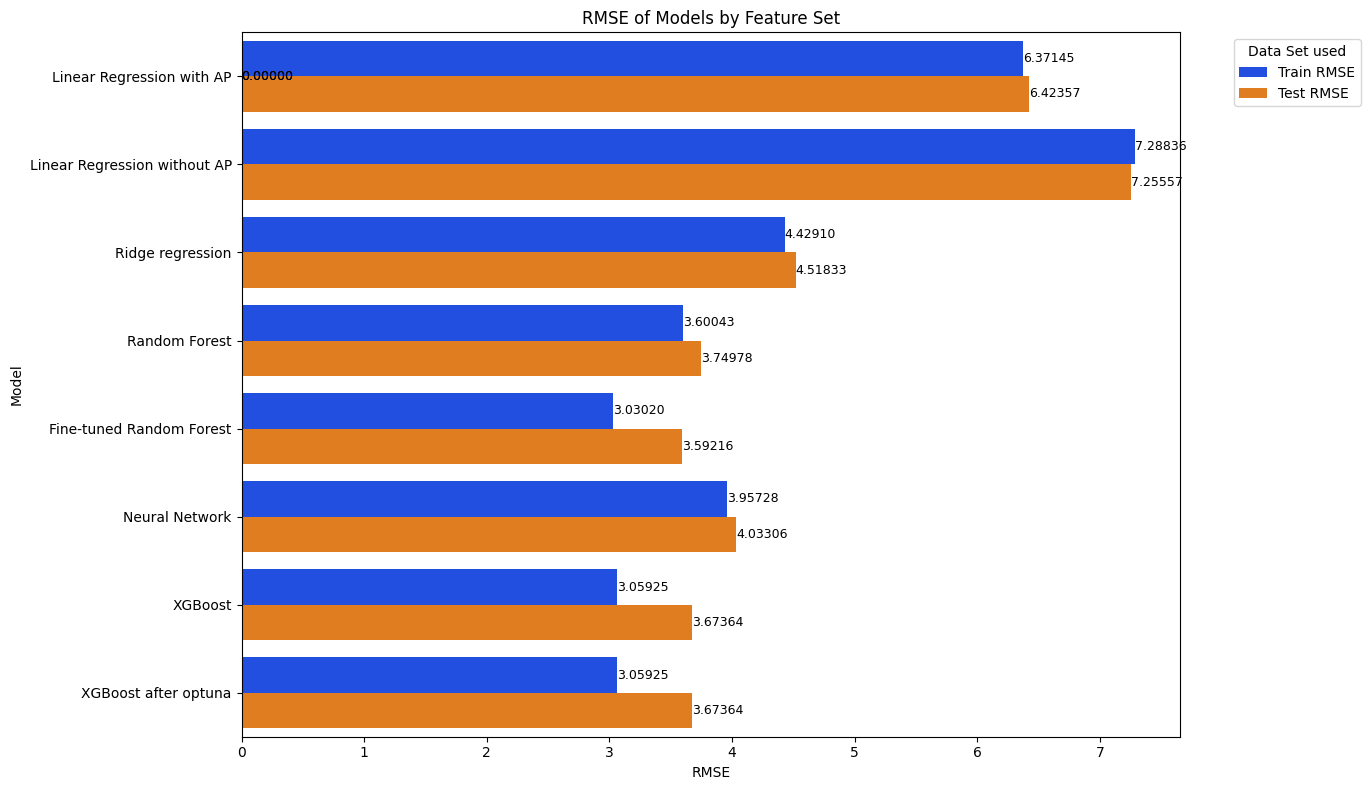

In [ ]:
# Plot the data
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='RMSE', y='Algorithms', hue='Data Set used', data=rmse_melted, palette='bright', orient='h')
plt.title('RMSE of Models by Feature Set')
plt.xlabel('RMSE')
plt.ylabel('Model')
plt.xscale('linear')  # Adjust the scale if necessary
plt.tight_layout()
plt.legend(title='Data Set used', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add RMSE values next to the bars
for p in ax.patches:
    width = p.get_width()
    rmse_value = f'{width:.5f}'  # Format as RMSE with 5 decimal places

    # Get x and y coordinates for text position
    x = width
    y = p.get_y() + p.get_height() / 2

    ax.annotate(rmse_value, (x, y), ha='left', va='center', fontsize=9, color='black')

plt.show()

# **Overview of Investigation and Model Evaluation**

**Introduction**

The aim of this investigation was to develop and evaluate various machine learning models to predict taxi fare amounts in New York City. The dataset consisted of 2 million rows of taxi trip data, including features such as pickup and dropoff locations, passenger count, and whether the trip started from an airport. The performance of each model was assessed using Root Mean Squared Error (RMSE) on both training and validation datasets.

**Data Preparation**

The initial steps involved data cleaning and feature engineering. The 'key' column was converted to datetime, and rows with missing dropoff values were removed. Outlier trips that extended beyond the bounding box of the test set or had unrealistic distances (e.g., trips over water) were also filtered out. The Haversine formula was used to calculate the distance of each trip in kilometres.

To analyse temporal patterns, the datetime column was split into separate columns for hour, day, month, and year. It was observed that taxi fares increased throughout the year and were higher during office hours (9 AM to 7 PM). Consequently, a new column indicating office hours was created. Clustering analysis was performed on the latitude and longitude data, resulting in 15 clusters. Additionally, trips starting within a 2 km radius of the three major airports were flagged, as airport trips typically have fixed fares.

**Model Training and Evaluation**

Various machine learning models were trained and evaluated:

1. Linear Regression with Airport Trips: The model performed with an RMSE of 6.37145 on the training set and 6.42357 on the validation set. The close values indicate minimal overfitting, but the high RMSE suggests limited predictive power.

2. Linear Regression without Airport Trips: Similar performance was observed with RMSE values of 7.28835 (train) and 7.25557 (test), suggesting that excluding airport trips did not significantly improve the model.

3. Ridge Regression: This regularised linear model had a training RMSE of 4.42910 and a validation RMSE of 4.51833, showing better performance than simple linear regression but still with a significant error margin.

4. Random Forest: The initial Random Forest model showed a training RMSE of 3.60043 and a validation RMSE of 3.74978. The relatively low error and minimal overfitting demonstrated the model's effectiveness.

5. Fine-tuned Random Forest: Further tuning improved the RMSE to 3.03020 (train) and 3.59216 (test), indicating robust performance and generalisability.

6. Neural Network: The neural network model achieved RMSE values of 3.95728 (train) and 4.03306 (test). While it showed good predictive power, the performance was slightly inferior to the fine-tuned Random Forest. I think I could have done this better, I feel like it needs lots of practice and experience for building good neural network. I will try my best this summer

7. XGBoost: This gradient boosting model showed promising results with a training RMSE of 3.05925 and a validation RMSE of 3.67364.

8. XGBoost after Optuna: Hyperparameter optimisation using Optuna further improved the model, maintaining a training RMSE of 3.05925 and validation RMSE of 3.67364, didn't increase much but still highlighting the model's robustness and reliability.


**Evaluation of Effectiveness and Reliability**

The evaluation of these models reveals several key insights:

* Linear Models: Both linear and ridge regression models exhibited high RMSE values, indicating limited effectiveness for this complex dataset. The linear assumptions do not capture the non-linear relationships present in the data.

* Random Forest Models: These models demonstrated significant improvements in RMSE, particularly after hyperparameter tuning. The fine-tuned Random Forest model provided a balance between predictive accuracy and generalisation, making it a reliable choice for this task.

* Neural Network: While the neural network performed reasonably well, it did not surpass the performance of the fine-tuned Random Forest or XGBoost models. This might be due to the complexity of tuning neural networks and the need for extensive computational resources as well as experience.

* XGBoost Models: Both standard and optimised XGBoost models delivered strong performance, with low RMSE values indicating high predictive power and reliability. I hope the use of Optuna for hyperparameter tuning further enhanced the model's effectiveness at least little bit, and confirming its suitability for this prediction task.

Conclusion
In conclusion, the investigation demonstrated that advanced machine learning models like Random Forest and XGBoost, particularly after fine-tuning, are highly effective and reliable for predicting taxi fares. These models effectively captured the complex relationships in the data, providing accurate and robust predictions. However it could have been better with drop off time since I didn't know it there was traffic or not also the the person maybe tipped the driver that could add up to total fare. Future work could explore additional feature engineering and model ensembling to further improve predictive performance.

In addition, I bought Colab Pro for this because I ran out of GPU runtime.

**Does this model give answer to my research question?**

I would say not fully. It is hard to predict just only on drop off and pick up location along with passenger count, I need time taken and other features.

Have a nice summer Nick, You are the best lecturer who delivers the most valuable lessons. Thanks